TorchVision Object Detection Finetuning Tutorial
================================================


For this tutorial, we will be finetuning a pre-trained [Mask
R-CNN](https://arxiv.org/abs/1703.06870) model on the [Penn-Fudan
Database for Pedestrian Detection and
Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains
170 images with 345 instances of pedestrians, and we will use it to
illustrate how to use the new features in torchvision in order to train
an object detection and instance segmentation model on a custom dataset.

Defining the Dataset
====================

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
`torch.utils.data.Dataset`{.interpreted-text role="class"} class, and
implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__`
should return a tuple:

-   image: `torchvision.tv_tensors.Image`{.interpreted-text
    role="class"} of shape `[3, H, W]`, a pure tensor, or a PIL Image of
    size `(H, W)`
-   target: a dict containing the following fields
    -   `boxes`,
        `torchvision.tv_tensors.BoundingBoxes`{.interpreted-text
        role="class"} of shape `[N, 4]`: the coordinates of the `N`
        bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to
        `W` and `0` to `H`
    -   `labels`, integer `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: the label for each bounding box. `0` represents
        always the background class.
    -   `image_id`, int: an image identifier. It should be unique
        between all the images in the dataset, and is used during
        evaluation
    -   `area`, float `torch.Tensor`{.interpreted-text role="class"} of
        shape `[N]`: the area of the bounding box. This is used during
        evaluation with the COCO metric, to separate the metric scores
        between small, medium and large boxes.
    -   `iscrowd`, uint8 `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: instances with `iscrowd=True` will be ignored
        during evaluation.
    -   (optionally) `masks`,
        `torchvision.tv_tensors.Mask`{.interpreted-text role="class"} of
        shape `[N, H, W]`: the segmentation masks for each one of the
        objects

If your dataset is compliant with above requirements then it will work
for both training and evaluation codes from the reference script.
Evaluation code will use scripts from `pycocotools` which can be
installed with `pip install pycocotools`.

One note on the `labels`. The model considers class `0` as background.
If your dataset does not contain the background class, you should not
have `0` in your `labels`. For example, assuming you have just two
classes, *cat* and *dog*, you can define `1` (not `0`) to represent
*cats* and `2` to represent *dogs*. So, for instance, if one of the
images has both classes, your `labels` tensor should look like `[1, 2]`.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a `get_height_and_width`
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
`__getitem__` , which loads the image in memory and is slower than if a
custom method is provided.

### Question: Why the method "\_\_getitem\_\_" must return the complicate structure "target"?

#### Answer: This structure describes all the information that are necessary to train an object recognition neural network: box coordinates, labels of each box, binary mask, etc.

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline

### Question: What is a PIL image?

#### Answer: More information on PIL on https://en.wikipedia.org/wiki/Python_Imaging_Library

--2024-11-12 13:46:06--  https://upload.wikimedia.org/wikipedia/commons/f/f1/Grayscale_4bit_palette_sample_image_-_gimp_dithered.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8153 (8.0K) [image/png]
Saving to: ‘Grayscale_4bit_palette_sample_image_-_gimp_dithered.png’

Grayscale_4bit_pale 100%[===================>]   7.96K  --.-KB/s    in 0s      

2024-11-12 13:46:07 (2.40 GB/s) - ‘Grayscale_4bit_palette_sample_image_-_gimp_dithered.png’ saved [8153/8153]



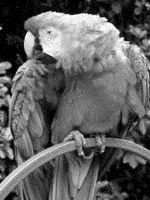

In [2]:
# Download an arbitrary image from the web
!wget https://upload.wikimedia.org/wikipedia/commons/f/f1/Grayscale_4bit_palette_sample_image_-_gimp_dithered.png
Image.open('Grayscale_4bit_palette_sample_image_-_gimp_dithered.png')

In [3]:
I = Image.open('Grayscale_4bit_palette_sample_image_-_gimp_dithered.png')
# The size returns a tuple (c,r): x is the number of columns and y is the number of rows
print(I.size)
# The inversion in the reshape is due to the matrix conversion: first, the number of rows, then the number of columns
pixels = np.array(I.getdata()).reshape((I.size[0], I.size[1]))
pixels.shape

(150, 200)


(150, 200)

## Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [4]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
# extract it
cd data
unzip PennFudanPed.zip

--2024-11-12 13:46:07--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  21.9MB/s    in 2.3s    

2024-11-12 13:46:10 (21.9 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

### Question: Check the structure of the folder "PennFudanPed" with shell commands.

#### Answer: This folder contraines the images, the annotations and the masks (for all the images).

In [5]:
!pwd

!ls -l ./data/PennFudanPed
!ls -l ./data/PennFudanPed/PedMasks | head -5
!ls -l ./data/PennFudanPed/PNGImages | head -5

/content
total 44
-rw------- 1 root root  1627 Sep 17  2007 added-object-list.txt
drwx------ 2 root root 12288 Oct 28  2007 Annotation
drwx------ 2 root root 12288 Oct 28  2007 PedMasks
drwx------ 2 root root 12288 Oct 28  2007 PNGImages
-rw------- 1 root root  2416 Oct 28  2007 readme.txt
total 736
-rw------- 1 root root 2757 Sep 17  2007 FudanPed00001_mask.png
-rw------- 1 root root 1674 Sep 17  2007 FudanPed00002_mask.png
-rw------- 1 root root 1807 Sep 17  2007 FudanPed00003_mask.png
-rw------- 1 root root 2080 Sep 17  2007 FudanPed00004_mask.png
total 52336
-rw------- 1 root root 497496 Sep  9  2007 FudanPed00001.png
-rw------- 1 root root 332429 Sep  9  2007 FudanPed00002.png
-rw------- 1 root root 331190 Sep  9  2007 FudanPed00003.png
-rw------- 1 root root 241120 Sep  9  2007 FudanPed00004.png


In [6]:
!cat ./data/PennFudanPed/Annotation/FudanPed00001.txt

# Compatible with PASCAL Annotation Version 1.00
Image filename : "PennFudanPed/PNGImages/FudanPed00001.png"
Image size (X x Y x C) : 559 x 536 x 3
Database : "The Penn-Fudan-Pedestrian Database"
Objects with ground truth : 2 { "PASpersonWalking" "PASpersonWalking" }
# Note there may be some objects not included in the ground truth list for they are severe-occluded
# or have very small size.
# Top left pixel co-ordinates : (1, 1)
# Details for pedestrian 1 ("PASpersonWalking")
Original label for object 1 "PASpersonWalking" : "PennFudanPed"
Bounding box for object 1 "PASpersonWalking" (Xmin, Ymin) - (Xmax, Ymax) : (160, 182) - (302, 431)
Pixel mask for object 1 "PASpersonWalking" : "PennFudanPed/PedMasks/FudanPed00001_mask.png"

# Details for pedestrian 2 ("PASpersonWalking")
Original label for object 2 "PASpersonWalking" : "PennFudanPed"
Bounding box for object 2 "PASpersonWalking" (Xmin, Ymin) - (Xmax, Ymax) : (420, 171) - (535, 486)
Pixel mask for object 2 "PASpersonWalking" : "PennF

### Question: Describe the content of "PennFudanPed/Annotation/FudanPed00001.txt".

#### Answer: We can check that the annotation contains the bounding box coordinates, the mask, etc.

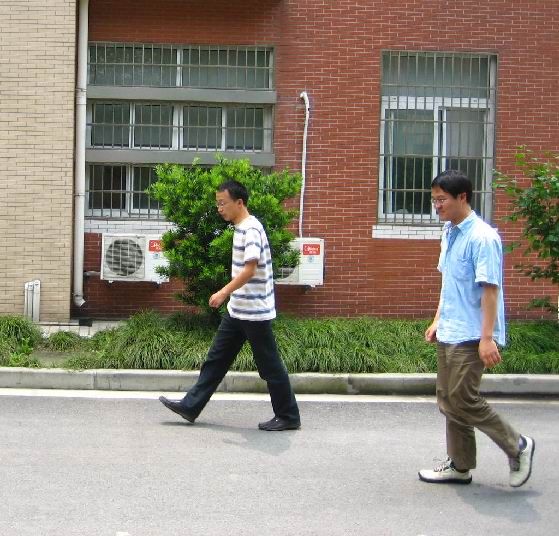

In [7]:
Image.open('./data/PennFudanPed/PNGImages/FudanPed00001.png')

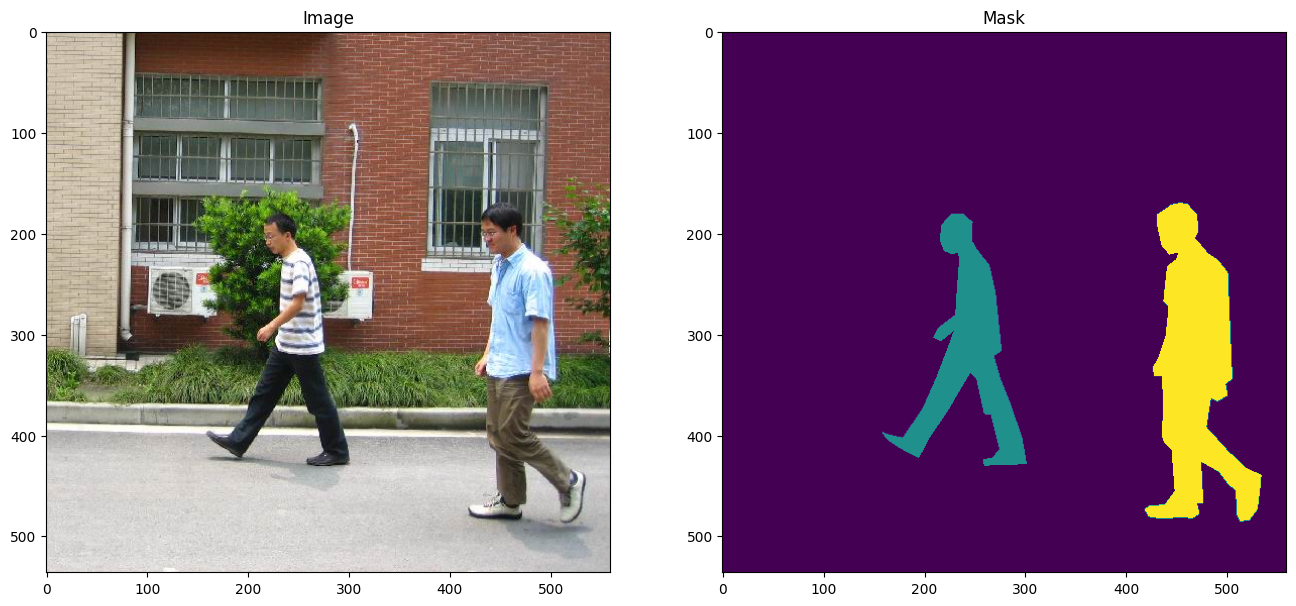

In [8]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("data/PennFudanPed/PNGImages/FudanPed00001.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00001_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

### Question: Print the pixel values of the mask. How many different values do you get?

In [9]:
# Answer:
mask = Image.open('./data/PennFudanPed/PedMasks/FudanPed00001_mask.png')
pixels = np.array(mask.getdata()).reshape((mask.size[1], mask.size[0]))
print(pixels)
print(pixels.shape)
print(np.unique(pixels))
print(pixels[200,:])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(536, 559)
[0 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Process the mask: find the masks for each single object.

In [10]:
mask = Image.open('./data/PennFudanPed/PedMasks/FudanPed00001_mask.png')
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it (by removing obj_ids[0])
obj_ids = obj_ids[1:]
print("obj_ids", obj_ids)

# split the color-encoded mask into a set of binary masks: one mask per object
print("Mask shape:", mask.shape)
masks = mask == obj_ids[:, None, None]
print(masks.shape)

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
print("Number of objects:", num_objs)
pos = np.where(masks[0])
print("Pixels of the first mask:")
print(pos)

obj_ids [1 2]
Mask shape: (536, 559)
(2, 536, 559)
Number of objects: 2
Pixels of the first mask:
(array([181, 181, 181, ..., 430, 430, 430]), array([227, 228, 229, ..., 262, 263, 264]))


Plot the mask; each object with a unique color

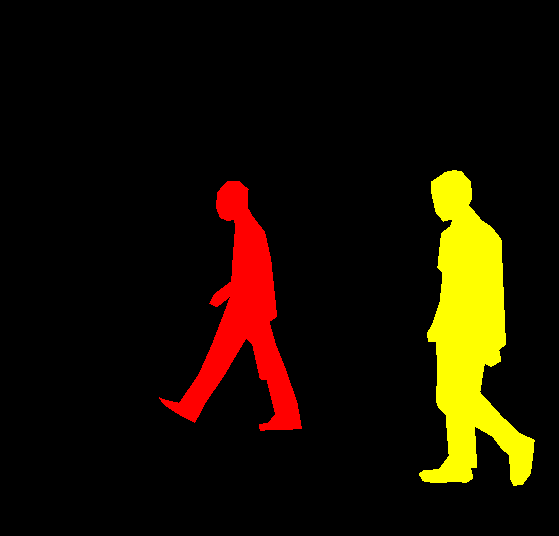

In [11]:
mask = Image.open('./data/PennFudanPed/PedMasks/FudanPed00001_mask.png')
mask = mask.convert('P') # If you have a P mode image, that means it is palettised.
# That means there is a palette with up to 256 different colours in it,
# and instead of storing 3 bytes for R, G and B for each pixel, you store 1 byte which is the index into the palette.
# Each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a torch.utils.data.Dataset class for this dataset.

So each image has a corresponding segmentation mask, where each color
correspond to a different instance. Let's write a
`torch.utils.data.Dataset`{.interpreted-text role="class"} class for
this dataset. In the code below, we are wrapping images, bounding boxes
and masks into `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} classes so that we will be able to apply torchvision
built-in transformations ([new Transforms
API](https://pytorch.org/vision/stable/transforms.html)) for the given
object detection and segmentation task. Namely, image tensors will be
wrapped by `torchvision.tv_tensors.Image`{.interpreted-text
role="class"}, bounding boxes into
`torchvision.tv_tensors.BoundingBoxes`{.interpreted-text role="class"}
and masks into `torchvision.tv_tensors.Mask`{.interpreted-text
role="class"}. As `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} are `torch.Tensor`{.interpreted-text role="class"}
subclasses, wrapped objects are also tensors and inherit the plain
`torch.Tensor`{.interpreted-text role="class"} API. For more information
about torchvision `tv_tensors` see [this
documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).


In [12]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Question: In the following cell, what is the type and the shape of the variable "masks"? What is the content returned by "\_\_getitem\_\_(self, idx)"?

#### Answer:
1. The shape of "masks" has already been discussed.
2. "np.where(masks[i])" selects the positions of the mask(corresponds to non-zero values)
3. "getitem(self, idx)" returns the image and the full set of annotations for the image

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

That's all for the dataset. Now let's define a model that can perform
predictions on this dataset.

Defining your model
===================

In this tutorial, we will be using [Mask
R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of
[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a
model that predicts both bounding boxes and class scores for potential
objects in the image.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts
segmentation masks for each instance.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image04.png)

There are two common situations where one might want to modify one of
the available models in TorchVision Model Zoo. The first is when we want
to start from a pre-trained model, and just finetune the last layer. The
other is when we want to replace the backbone of the model with a
different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.

1 - Finetuning from a pretrained model
--------------------------------------

Let's suppose that you want to start from a model pre-trained on COCO
and want to finetune it for your particular classes. Here is a possible
way of doing it:


In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 175MB/s]


2 - Modifying the model to add a different backbone
===================================================


### Question: What is the backbone neural network used jointly with Mask R-CNN?

#### Answer:

The backbone neural network is resnet50.

More details on it on https://pytorch.org/vision/stable/models.html

In [14]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 66.5MB/s]


Object detection and instance segmentation model for PennFudan Dataset
======================================================================

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:


In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That's it, this will make `model` be ready to be trained and evaluated
on your custom dataset.

Putting everything together
===========================

In `references/detection/`, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
`references/detection/engine.py` and `references/detection/utils.py`.
Just download everything under `references/detection` to your folder and
use them here. On Linux if you have `wget`, you can download them using
below commands:


In [16]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

Since v0.15.0 torchvision provides [new Transforms
API](https://pytorch.org/vision/stable/transforms.html) to easily write
data augmentation pipelines for Object Detection and Segmentation tasks.

Let's write some helper functions for data augmentation /
transformation:


### Question: what is the goal of data augmentation?

#### Answer:

Data augmentation is used to increase the size of the training set. For example, a given image can be duplicated and modified with a rotation, an horizontal flip, etc.

In [17]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Testing `forward()` method
=====================================

Before iterating over the dataset, it\'s good to see what the model
expects during training and inference time on sample data.


In [18]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1686, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0250, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0218, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0014, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let's now write the main function which performs the training and the
validation:


### Question: In the following cell, we use the GPU. Explain briefly how the GPU is used.

#### Answer:

All the tensors involved in the neural network are declared on the GPU. This simple change is sufficient to run the neural network on the GPU, including the optimization step.

In [19]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 153MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:03:18  lr: 0.000090  loss: 1.4479 (1.4479)  loss_classifier: 0.4935 (0.4935)  loss_box_reg: 0.2568 (0.2568)  loss_mask: 0.6668 (0.6668)  loss_objectness: 0.0284 (0.0284)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 3.3128  data: 0.0219  max mem: 2216
Epoch: [0]  [10/60]  eta: 0:00:40  lr: 0.000936  loss: 1.2473 (1.2356)  loss_classifier: 0.3831 (0.3787)  loss_box_reg: 0.2885 (0.2908)  loss_mask: 0.5349 (0.5316)  loss_objectness: 0.0284 (0.0288)  loss_rpn_box_reg: 0.0050 (0.0059)  time: 0.8182  data: 0.0318  max mem: 3042
Epoch: [0]  [20/60]  eta: 0:00:27  lr: 0.001783  loss: 0.8371 (0.9377)  loss_classifier: 0.2313 (0.2708)  loss_box_reg: 0.2429 (0.2652)  loss_mask: 0.2438 (0.3767)  loss_objectness: 0.0100 (0.0201)  loss_rpn_box_reg: 0.0042 (0.0048)  time: 0.5548  data: 0.0339  max mem: 3042
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.4915 (0.8012)  loss_classifier: 0.0807 (0.2067)  loss_box_reg: 0.2150 (0.2573)  loss_mask: 0.1905 (0.3168)  loss_ob

### Question: In the previous cell, what is the "lr_scheduler"? How does it work?

#### Answer:

Decays the learning rate of each parameter group by gamma every step_size epochs.

What do the predictions look like? Let's take one image in the
dataset and verify


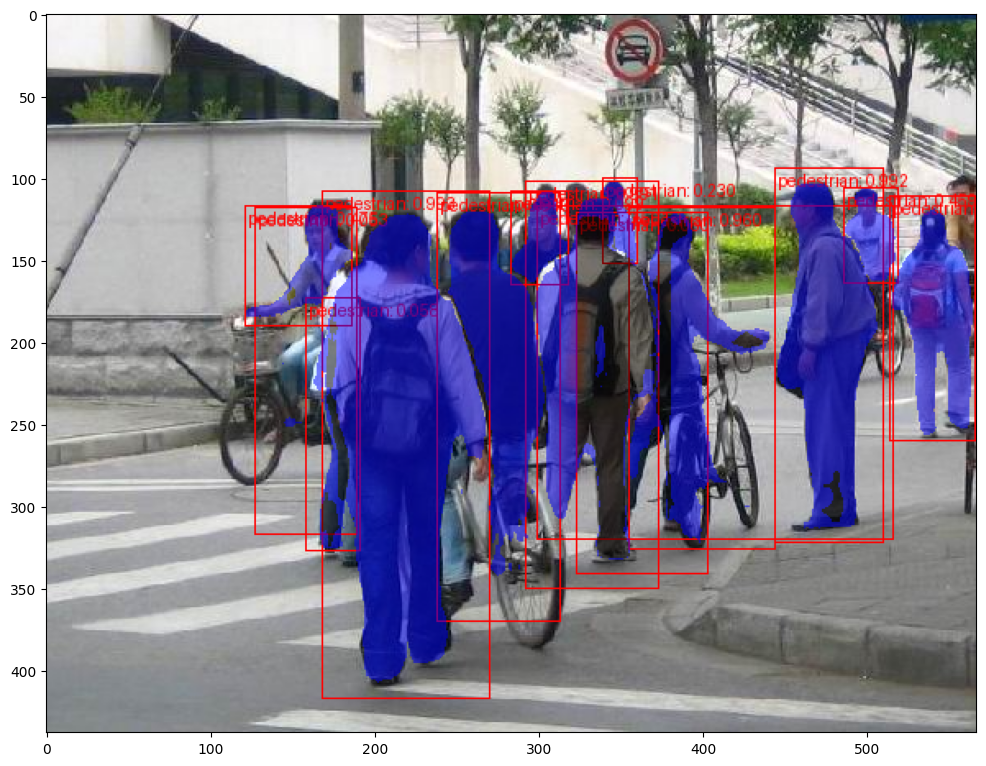

In [20]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

The results look good!


### Question: Select the image "FudanPed00001.png" and test it with the trained model. The output will be named "prediction". It will be used in the remaining cells.

In [21]:
# Answer:

# pick the image
image = read_image("data/PennFudanPed/PNGImages/FudanPed00001.png")
eval_transform = get_transform(train=False)
img = eval_transform(image)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

### Question: Analyze the content of the prediction. What are its components?

#### Answer:

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [22]:
prediction

[{'boxes': tensor([[154.2378, 175.4294, 298.2619, 429.6084],
          [417.9912, 158.8811, 537.6704, 489.3640]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9962, 0.9921], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

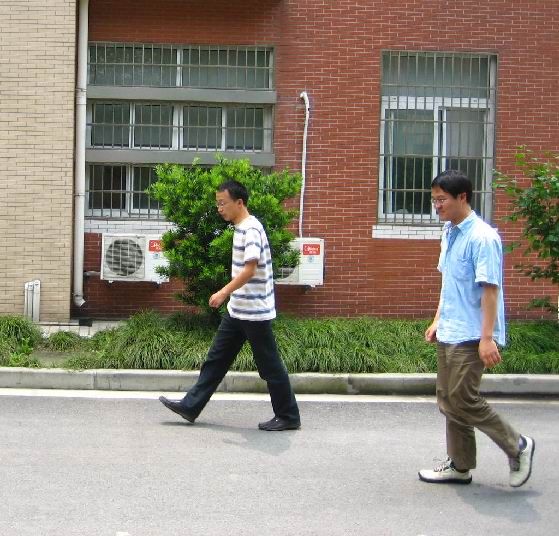

In [23]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

Let us visualize the histogram of the mask values for the first prediction

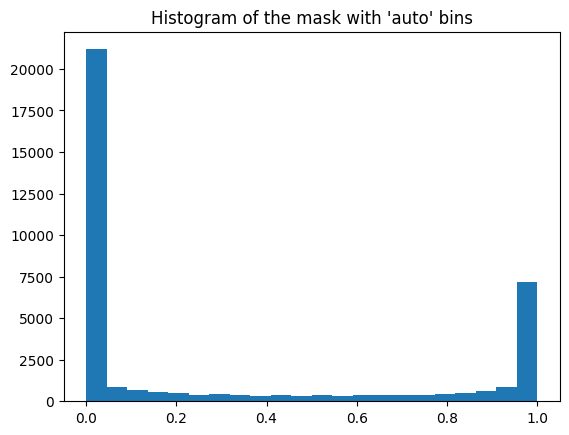

In [24]:
import matplotlib.pyplot as plt
a = np.unique(prediction[0]['masks'][0, 0].cpu().numpy())
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of the mask with 'auto' bins")
plt.show()

### Question: Show as an image the mask of the first prediction.

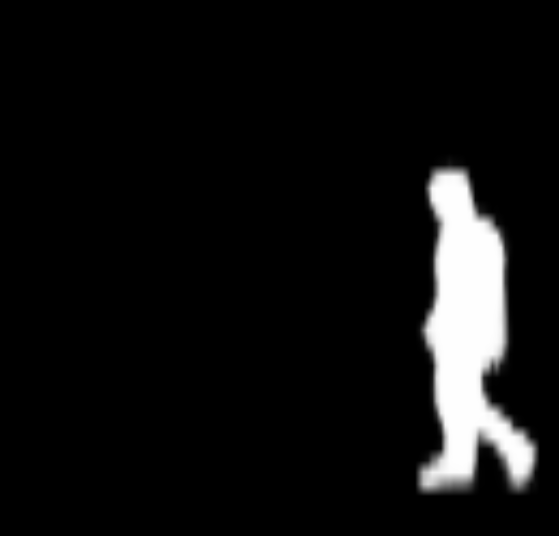

In [25]:
# Answer:

Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())